# Collaborative Filtering on Google Analytics Data


### Learning objectives
1. Prepare the user-item matrix and use it with WALS.
2. Train a `WALSMatrixFactorization` within TensorFlow locally and on AI Platform.
3. Visualize the embedding vectors with principal components analysis.


## Overview
This notebook demonstrates how to implement a WALS matrix refactorization approach to do collaborative filtering.

Each learning objective will correspond to a __#TODO__ in the notebook, where you will complete the notebook cell's code before running the cell. Refer to the [solution notebook](../solutions/wals.ipynb) for reference.


In [1]:
import os
PROJECT = "testbed-412418" # REPLACE WITH YOUR PROJECT ID
BUCKET = "testbed-412418" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = "2.15"

In [2]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION


To update your Application Default Credentials quota project, use the `gcloud auth application-default set-quota-project` command.
Updated property [core/project].
Updated property [compute/region].


In [3]:
import tensorflow as tf
print(tf.__version__)

2024-03-09 12:45:37.898905: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 12:45:38.221214: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


## Create raw dataset
<p>
For collaborative filtering, you don't need to know anything about either the users or the content. Essentially, all you need to know is userId, itemId, and rating that the particular user gave the particular item.
<p>
In this case, you are working with newspaper articles. The company doesn't ask their users to rate the articles. However, you can use the time-spent on the page as a proxy for rating.
<p>
Normally, you would also add a time filter to this ("latest 7 days"), but your dataset is itself limited to a few days.

In [4]:
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

sql = """
WITH CTE_visitor_page_content AS (
    SELECT
        # Schema: https://support.google.com/analytics/answer/3437719?hl=en
        # For a completely unique visit-session ID, you combine combination of fullVisitorId and visitNumber:
        CONCAT(fullVisitorID,'-',CAST(visitNumber AS STRING)) AS visitorId,
        (SELECT MAX(IF(index=10, value, NULL)) FROM UNNEST(hits.customDimensions)) AS latestContentId,  
        (LEAD(hits.time, 1) OVER (PARTITION BY fullVisitorId ORDER BY hits.time ASC) - hits.time) AS session_duration 
    FROM
        `cloud-training-demos.GA360_test.ga_sessions_sample`,   
        UNNEST(hits) AS hits
    WHERE 
        # only include hits on pages
        hits.type = "PAGE"
GROUP BY   
        fullVisitorId,
        visitNumber,
        latestContentId,
        hits.time )
-- Aggregate web stats
SELECT   
    visitorId,
    latestContentId as contentId,
    SUM(session_duration) AS session_duration
FROM
    CTE_visitor_page_content
WHERE
    latestContentId IS NOT NULL 
GROUP BY
    visitorId, 
    latestContentId
HAVING 
    session_duration > 0
"""

df = bq.query(sql).to_dataframe()
df.head()

/home/sferro/miniconda3/envs/dev-3712/envs/googleML2/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


,visitorId,contentId,session_duration
0,1128668233820115027-1,299293352,174546
1,1206119881575218085-174,299942248,39619
2,1955822103969464021-944,299913879,100985
3,2349169794698978793-3,299912151,21451
4,3025206181189463166-1,791298,79188


In [5]:
stats = df.describe()
stats

,session_duration
count,283124.0
mean,125249.144523
std,231842.797581
min,1.0
25%,16234.0
50%,56620.5
75%,127640.5
max,7690598.0


<Axes: ylabel='Frequency'>

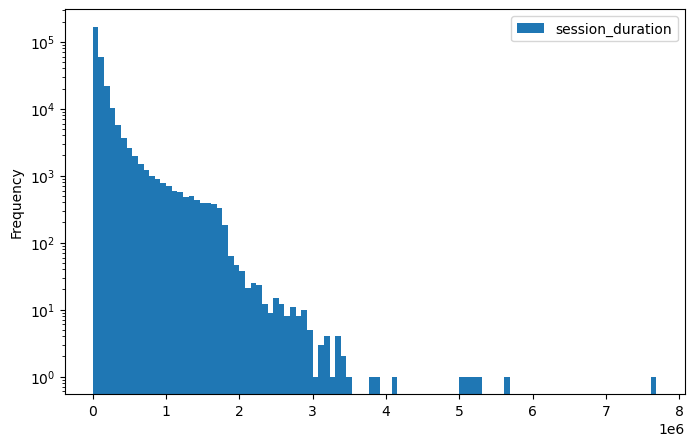

In [6]:
df[["session_duration"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

<Axes: ylabel='Frequency'>

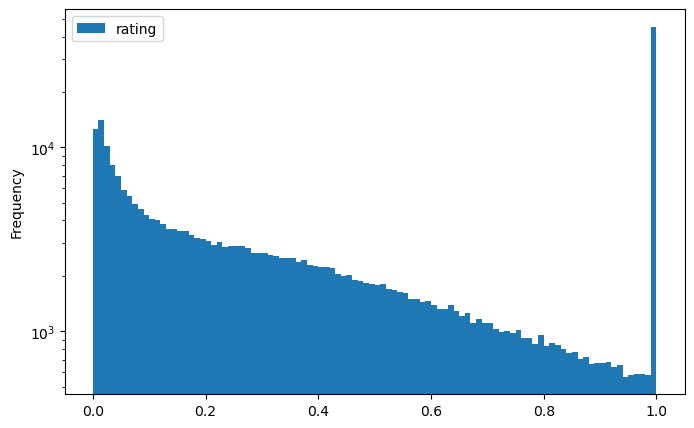

In [7]:
# The rating is the session_duration scaled to be in the range 0-1.  This will help with training.
median = stats.loc["50%", "session_duration"]
df["rating"] = 0.3 * df["session_duration"] / median
df.loc[df["rating"] > 1, "rating"] = 1
df[["rating"]].plot(kind="hist", logy=True, bins=100, figsize=[8,5])

In [8]:
del df["session_duration"]

In [9]:
%%bash
rm -rf data
mkdir data

In [17]:
# Write object to a comma-separated values (csv) file.
# TODO 1: Your code here
df.to_csv('data/collab_raw.csv', header=False, index=False)

In [18]:
!head data/collab_raw.csv

1128668233820115027-1,299293352,0.9248205155376585
1206119881575218085-174,299942248,0.20991866903330064
1955822103969464021-944,299913879,0.5350623890640316
2349169794698978793-3,299912151,0.11365671444088273
3025206181189463166-1,791298,0.41957241635096826
3093020497862839474-2,109249612,0.1685220017484833
354444681398355987-356,299814842,0.12644713487164544
3618953176082749245-737,299830996,0.3845921530187829
4077654601012599143-12,299934703,0.16457996661986385
4826080286115541867-1,299273864,0.5904204307627097


## Create dataset for WALS
<p>
The raw dataset (above) won't work for WALS:
<ol>
<li> The userId and itemId have to be 0,1,2 ... so you need to create a mapping from visitorId (in the raw data) to userId and contentId (in the raw data) to itemId.
<li> You will need to save the above mapping to a file because at prediction time, you'll need to know how to map the contentId in the table above to the itemId.
<li> You'll need two files: a "rows" dataset where all the items for a particular user are listed; and a "columns" dataset where all the users for a particular item are listed.
</ol>

<p>

### Mapping

In [19]:
import pandas as pd
import numpy as np
def create_mapping(values, filename):
    with open(filename, 'w') as ofp:
        value_to_id = {value:idx for idx, value in enumerate(values.unique())}
        for value, idx in value_to_id.items():
            ofp.write("{},{}\n".format(value, idx))
    return value_to_id

df = pd.read_csv(filepath_or_buffer = "data/collab_raw.csv",
                 header = None,
                 names = ["visitorId", "contentId", "rating"],
                dtype = {"visitorId": str, "contentId": str, "rating": np.float64})
df.to_csv(path_or_buf = "data/collab_raw.csv", index = False, header = False)
user_mapping = create_mapping(df["visitorId"], "data/users.csv")
item_mapping = create_mapping(df["contentId"], "data/items.csv")

In [13]:
!head -3 data/*.csv

==> data/collab_raw.csv <==
1012012094517511217-1,299949290,1.0
1614877438160481626-349,29455408,1.0
1815317450115839569-235,299807267,0.8569622728727375

==> data/items.csv <==
299949290,0
29455408,1
299807267,2

==> data/users.csv <==
1012012094517511217-1,0
1614877438160481626-349,1
1815317450115839569-235,2


In [24]:
type(user_mapping.get)


builtin_function_or_method

In [26]:
df["userId"] = df["visitorId"].map(user_mapping.get)
df["itemId"] = df["contentId"].map(item_mapping.get)

In [27]:
mapped_df = df[["userId", "itemId", "rating"]]
mapped_df.to_csv(path_or_buf = "data/collab_mapped.csv", index = False, header = False)
mapped_df.head()

,userId,itemId,rating
0,0,0,0.924821
1,1,1,0.209919
2,2,2,0.535062
3,3,3,0.113657
4,4,4,0.419572


### Creating rows and columns datasets

In [28]:
import pandas as pd
import numpy as np
mapped_df = pd.read_csv(filepath_or_buffer = "data/collab_mapped.csv", header = None, names = ["userId", "itemId", "rating"])
mapped_df.head()

,userId,itemId,rating
0,0,0,0.924821
1,1,1,0.209919
2,2,2,0.535062
3,3,3,0.113657
4,4,4,0.419572


In [29]:
NITEMS = np.max(mapped_df["itemId"]) + 1
NUSERS = np.max(mapped_df["userId"]) + 1
mapped_df["rating"] = np.round(mapped_df["rating"].values, 2)
print("{} items, {} users, {} interactions".format( NITEMS, NUSERS, len(mapped_df) ))

5596 items, 118858 users, 283124 interactions


In [30]:
grouped_by_items = mapped_df.groupby("itemId")
iter = 0
for item, grouped in grouped_by_items:
    print(item, grouped["userId"].values, grouped["rating"].values)
    iter = iter + 1
    if iter > 5:
        break

0 [    0  6473 11162 18589 16702 24831 25907 29030 35272 45375 49547] [0.92 1.   0.06 1.   0.77 1.   0.71 0.07 0.44 0.13 0.01]
1 [    1   247   285  2864  2909  2929  3289  4119  4773  5822  5976  6075
  6440  6661  6778  7156  8271  8852  9172  9425  9960 10103 10532  1835
 11049 11083 11477 11655  3195  3960 12702 12837 14443 14535 15463 15714
 16229 16367 11702  4127 17767 18107 18309 18602 18678 19031 15279  4727
 20371  2327 20727 20798 21450  3943 19690 21952 10205 22233 22504 22678
 22710 10964 23205 23407 24189 24261  1245 25096 25736 17497  1409 15721
 26773 26797  8011  8063 27453 27622 19249 28130 26323 28462 28911 25317
 29395 30019 30080 30840 14065 31349  3387 31909   838 32109 32162 32189
 32312  7563 33197 14504 33526 33659 33951 34194 34233 34264 10768  5961
 11931 29677 27779 35731 36477 36534 36885 37097 37192 37230 37815 37869
 38218 38440 23579 38960 32216 39418  4742 15793 39684 39784 29246 23349
 14420 40437 40596 22011 40823 26574 30526 37747 22903 31051 42102 4

In [34]:
mapped_df.describe()

,userId,itemId,rating
count,283124.000000,283124.000000,283124.000000
mean,45517.935138,3726.982520,0.403185
std,33412.540839,2531.352931,0.351710
min,0.000000,0.000000,0.000000
25%,16307.000000,217.000000,0.090000
50%,39071.500000,5553.000000,0.300000
75%,70874.000000,5572.000000,0.680000
max,118857.000000,5595.000000,1.000000


In [35]:
grouped_by_items.describe()

userId                                                         \
         count          mean           std    min       25%       50%   
itemId                                                                  
0         11.0  23898.909091  15481.160205    0.0  13932.00   24831.0   
1        253.0  26284.525692  16585.252377    1.0  11083.00   25736.0   
2        998.0  23993.209419  16153.092848    2.0  10256.00   21504.5   
3        763.0  25816.133683  16311.633358    3.0  11039.50   25033.0   
4          3.0  29129.666667  26294.694452    4.0  18134.00   36264.0   
...        ...           ...           ...    ...       ...       ...   
5591    2062.0  88373.198351  36712.255275  206.0  62115.50  113245.5   
5592    4473.0  77658.720322  40844.945010   51.0  38845.00  102867.0   
5593    1784.0  74408.062780  42261.466639   72.0  32935.00   93911.0   
5594    2792.0  77591.144699  42499.077646   52.0  36021.75  104451.5   
5595    4383.0  84347.529774  41295.107683   46.0  44010.50  112718.0   

                             rating                                          \
              75%       max   count      mean       std   min     25%   50%   
itemId                                                                        
0        32151.00   49547.0    11.0  0.555455  0.420556  0.01  0.1000  0.71   
1        40823.00   56922.0   253.0  0.340909  0.328131  0.00  0.0700  0.23   
2        36379.75   57170.0   998.0  0.265721  0.252251  0.00  0.1100  0.18   
3        39334.50   57032.0   763.0  0.261743  0.290218  0.00  0.0500  0.14   
4        43692.50   51121.0     3.0  0.720000  0.290517  0.42  0.5800  0.74   
...           ...       ...     ...       ...       ...   ...     ...   ...   
5591    113760.75  114276.0  2062.0  0.552017  0.418740  0.00  0.0900  0.58   
5592    114734.00  115852.0  4473.0  0.279982  0.311933  0.00  0.0300  0.15   
5593    115921.25  116367.0  1784.0  0.486564  0.361262  0.00  0.1375  0.43   
5594    116559.25  117257.0  2792.0  0.420512  0.401583  0.00  0.0400  0.26   
5595    117761.50  118857.0  4383.0  0.481727  0.408847  0.00  0.0600  0.39   

                   
         75%  max  
itemId             
0       0.96  1.0  
1       0.51  1.0  
2       0.31  1.0  
3       0.37  1.0  
4       0.87  1.0  
...      ...  ...  
5591    1.00  1.0  
5592    0.41  1.0  
5593    0.86  1.0  
5594    0.92  1.0  
5595    1.00  1.0  

[5596 rows x 16 columns]

In [36]:
import tensorflow as tf
grouped_by_items = mapped_df.groupby("itemId")
with tf.io.TFRecordWriter("data/users_for_item") as ofp:
    for item, grouped in grouped_by_items:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [item])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["userId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [37]:
grouped_by_users = mapped_df.groupby("userId")
with tf.io.TFRecordWriter("data/items_for_user") as ofp:
    for user, grouped in grouped_by_users:
        example = tf.train.Example(features = tf.train.Features(feature = {
            "key": tf.train.Feature(int64_list = tf.train.Int64List(value = [user])),
            "indices": tf.train.Feature(int64_list = tf.train.Int64List(value = grouped["itemId"].values)),
            "values": tf.train.Feature(float_list = tf.train.FloatList(value = grouped["rating"].values))
        }))
        ofp.write(example.SerializeToString())

In [38]:
!ls -lrt data

total 36256
-rw-r--r-- 1 sferro sferro 14066967 Mar  9 13:08 collab_raw.csv
-rw-r--r-- 1 sferro sferro  3465266 Mar  9 13:08 users.csv
-rw-r--r-- 1 sferro sferro    81116 Mar  9 13:08 items.csv
-rw-r--r-- 1 sferro sferro  7627395 Mar  9 13:15 collab_mapped.csv
-rw-r--r-- 1 sferro sferro  2282759 Mar  9 13:30 users_for_item
-rw-r--r-- 1 sferro sferro  9587189 Mar  9 13:31 items_for_user


To summarize, you created the following data files from collab_raw.csv:
<ol>
<li> ```collab_mapped.csv``` is essentially the same data as in ```collab_raw.csv``` except that ```visitorId``` and ```contentId``` which are business-specific have been mapped to ```userId``` and ```itemId``` which are enumerated in 0,1,2,....  The mappings themselves are stored in ```items.csv``` and ```users.csv``` so that they can be used during inference.
<li> ```users_for_item``` contains all the users/ratings for each item in TFExample format
<li> ```items_for_user``` contains all the items/ratings for each user in TFExample format
</ol>

## Train with WALS

Once you have the dataset, do matrix factorization with WALS using the [WALSMatrixFactorization](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/contrib/factorization/WALSMatrixFactorization) in the contrib directory.
This is an estimator model, so it should be relatively familiar.
<p>
As usual, you write an input_fn to provide the data to the model, and then create the Estimator to do train_and_evaluate.
Because it is in contrib and hasn't moved over to tf.estimator yet, you use tf.contrib.learn.Experiment to handle the training loop.<p>
Make sure to replace <strong># TODO</strong> in below code.

In [41]:
import os
import tensorflow as tf
from tensorflow.python.lib.io import file_io
from tensorflow.contrib.factorization import WALSMatrixFactorization
  
def read_dataset(mode, args):
    def decode_example(protos, vocab_size):
        # TODO 2: Your code here
        features =  {
            "key": tf.io.FixedLenFeature(shape = [1], dtype = tf.int64),
            "indices": tf.io.VarLenFeature(tf.int64),
            "values": tf.io.VarLenFeature(tf.float32)
        }
        parsed_features = tf.parse_single_example(serialized = protos, features = features)
        values = tf.sparse_merge(sp_ids = parsed_features["indices"], sp_values = parsed_features["values"], vocab_size = vocab_size)
        # Save key to remap after batching
        # This is a temporary workaround to assign correct row numbers in each batch.
        # You can ignore details of this part and remap_keys().
        key = parsed_features["key"]
        decoded_sparse_tensor = tf.SparseTensor(indices = tf.concat(values = [values.indices, [key]], axis = 0), 
                                                values = tf.concat(values = [values.values, [0.0]], axis = 0), 
                                                dense_shape = values.dense_shape)
        return
  
  
    def remap_keys(sparse_tensor):
        # Current indices of your SparseTensor that you need to fix
        bad_indices = sparse_tensor.indices # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)
        # Current values of your SparseTensor that you need to fix
        bad_values = sparse_tensor.values # shape = (current_batch_size * (number_of_items/users[i] + 1),)

        # Since batch is ordered, the last value for a batch index is the user
        # Find where the batch index chages to extract the user rows
        # 1 where user, else 0
        user_mask = tf.concat(values = [bad_indices[1:,0] - bad_indices[:-1,0], tf.constant(value = [1], dtype = tf.int64)], axis = 0) # shape = (current_batch_size * (number_of_items/users[i] + 1), 2)

        # Mask out the user rows from the values
        good_values = tf.boolean_mask(tensor = bad_values, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        item_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 0)) # shape = (current_batch_size * number_of_items/users[i],)
        user_indices = tf.boolean_mask(tensor = bad_indices, mask = tf.equal(x = user_mask, y = 1))[:, 1] # shape = (current_batch_size,)

        good_user_indices = tf.gather(params = user_indices, indices = item_indices[:,0]) # shape = (current_batch_size * number_of_items/users[i],)

        # User and item indices are rank 1, need to make rank 1 to concat
        good_user_indices_expanded = tf.expand_dims(input = good_user_indices, axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_item_indices_expanded = tf.expand_dims(input = item_indices[:, 1], axis = -1) # shape = (current_batch_size * number_of_items/users[i], 1)
        good_indices = tf.concat(values = [good_user_indices_expanded, good_item_indices_expanded], axis = 1) # shape = (current_batch_size * number_of_items/users[i], 2)

        remapped_sparse_tensor = tf.SparseTensor(indices = good_indices, values = good_values, dense_shape = sparse_tensor.dense_shape)
        return remapped_sparse_tensor

    
    def parse_tfrecords(filename, vocab_size):
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        files = tf.gfile.Glob(filename = os.path.join(args["input_path"], filename))

        # Create dataset from file list
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.map(map_func = lambda x: decode_example(x, vocab_size))
        dataset = dataset.repeat(count = num_epochs)
        dataset = dataset.batch(batch_size = args["batch_size"])
        dataset = dataset.map(map_func = lambda x: remap_keys(x))
        return dataset.make_one_shot_iterator().get_next()
  
    def _input_fn():
        features = {
            WALSMatrixFactorization.INPUT_ROWS: parse_tfrecords("items_for_user", args["nitems"]),
            WALSMatrixFactorization.INPUT_COLS: parse_tfrecords("users_for_item", args["nusers"]),
            WALSMatrixFactorization.PROJECT_ROW: tf.constant(True)
        }
        return features, None

    return _input_fn

ModuleNotFoundError: No module named 'tensorflow.contrib'

This code is helpful in developing the input function. You don't need it in production.

In [23]:
def try_out():
    with tf.Session() as sess:
        fn = read_dataset(
            mode = tf.estimator.ModeKeys.EVAL, 
            args = {"input_path": "data", "batch_size": 4, "nitems": NITEMS, "nusers": NUSERS})
        feats, _ = fn()
        
        print(feats["input_rows"].eval())
        print(feats["input_rows"].eval())

try_out()

2022-05-16 17:40:20.509438: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200225000 Hz
2022-05-16 17:40:20.510339: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a7e3dcc0d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-16 17:40:20.510379: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-16 17:40:20.511445: I tensorflow/core/common_runtime/process_util.cc:136] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Instructions for updating:
No similar op available at this time.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
SparseTensorValue(indices=array([[   0,    0],
       [   0,  129],
       [   0,  233],
       [   0,  662],
       [   1,    1],
       [   1,    9],
       [   1,   13],
       [   1,   52],
       [   1,  160],
       [   1,  200],
       [   1,  261],
       [   1, 5635],
       [   2,    2],
       [   2,  182],
       [   3,    3],
       [   3,  144],
       [   3, 5611],
       [   3, 5615],
       [   3, 5616],
       [   3, 5620],
       [   3, 5623],
       [   3, 5624],
       [   3, 5637],
       [   3, 5638]]), values=array([1.  , 0.89, 1.  , 1.  , 1.  , 0.07, 0.34, 0.

In [25]:
def find_top_k(user, item_factors, k):
    all_items = tf.matmul(a = tf.expand_dims(input = user, axis = 0), b = tf.transpose(a = item_factors))
    topk = tf.nn.top_k(input = all_items, k = k)
    return tf.cast(x = topk.indices, dtype = tf.int64)
    
def batch_predict(args):
    import numpy as np
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        # This is how you would get the row factors for out-of-vocab user data
        # row_factors = list(estimator.get_projections(input_fn=read_dataset(tf.estimator.ModeKeys.EVAL, args)))
        # user_factors = tf.convert_to_tensor(np.array(row_factors))

        # But for in-vocab data, the row factors are already in the checkpoint
        user_factors = tf.convert_to_tensor(value = estimator.get_row_factors()[0]) # (nusers, nembeds)
        # In either case, you have to assume catalog doesn"t change, so col_factors are read in
        item_factors = tf.convert_to_tensor(value = estimator.get_col_factors()[0])# (nitems, nembeds)

        # For each user, find the top K items
        topk = tf.squeeze(input = tf.map_fn(fn = lambda user: find_top_k(user, item_factors, args["topk"]), elems = user_factors, dtype = tf.int64))
        with file_io.FileIO(os.path.join(args["output_dir"], "batch_pred.txt"), mode = 'w') as f:
            for best_items_for_user in topk.eval():
                f.write(",".join(str(x) for x in best_items_for_user) + '\n')

def train_and_evaluate(args):
    train_steps = int(0.5 + (1.0 * args["num_epochs"] * args["nusers"]) / args["batch_size"])
    steps_in_epoch = int(0.5 + args["nusers"] / args["batch_size"])
    print("Will train for {} steps, evaluating once every {} steps".format(train_steps, steps_in_epoch))
    def experiment_fn(output_dir):
        return tf.contrib.learn.Experiment(
            tf.contrib.factorization.WALSMatrixFactorization(
                num_rows = args["nusers"], 
                num_cols = args["nitems"],
                embedding_dimension = args["n_embeds"],
                model_dir = args["output_dir"]),
            train_input_fn = read_dataset(tf.estimator.ModeKeys.TRAIN, args),
            eval_input_fn = read_dataset(tf.estimator.ModeKeys.EVAL, args),
            train_steps = train_steps,
            eval_steps = 1,
            min_eval_frequency = steps_in_epoch
        )

    from tensorflow.contrib.learn.python.learn import learn_runner
    learn_runner.run(experiment_fn = experiment_fn, output_dir = args["output_dir"])
    
    batch_predict(args)

In [26]:
import shutil
shutil.rmtree(path = "wals_trained", ignore_errors=True)
train_and_evaluate({
    "output_dir": "wals_trained",
    "input_path": "data/",
    "num_epochs": 0.05,
    "nitems": NITEMS,
    "nusers": NUSERS,

    "batch_size": 512,
    "n_embeds": 10,
    "topk": 3
  })

Will train for 12 steps, evaluating once every 236 steps
Instructions for updating:
Use tf.estimator.train_and_evaluate.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc3e838dfd0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local

In [27]:
!ls wals_trained

batch_pred.txt
checkpoint
eval
events.out.tfevents.1652722839.tensorflow-1-15-20220516-225105
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-12.data-00000-of-00001
model.ckpt-12.index
model.ckpt-12.meta


In [28]:
!head wals_trained/batch_pred.txt

5526,129,885
4712,2402,2620
2710,139,1001
885,5526,3450
202,370,2839
4972,1085,4505
4896,1687,2833
3418,5095,2702
3537,479,4896
1001,4516,2347


## Run as a Python module

Let's run it as Python module for just a few steps.

In [29]:
os.environ["NITEMS"] = str(NITEMS)
os.environ["NUSERS"] = str(NUSERS)

In [30]:
%%bash
rm -rf wals.tar.gz wals_trained
gcloud ai-platform local train \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    -- \
    --output_dir=${PWD}/wals_trained \
    --input_path=${PWD}/data \
    --num_epochs=0.01 --nitems=${NITEMS} --nusers=${NUSERS} \
    --job-dir=./tmp

Will train for 2 steps, evaluating once every 236 steps




Instructions for updating:
Use tf.estimator.train_and_evaluate.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdf7d13df90>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'cloud', '_is_chief': True, '_evaluation_master': '', '_train

## Get row and column factors

Once you have a trained WALS model, you can get row and column factors (user and item embeddings) from the checkpoint file. You'll look at how to use these in the section on building a recommendation system using deep neural networks.

In [33]:
def get_factors(args):
    with tf.Session() as sess:
        estimator = tf.contrib.factorization.WALSMatrixFactorization(
            num_rows = args["nusers"], 
            num_cols = args["nitems"],
            embedding_dimension = args["n_embeds"],
            model_dir = args["output_dir"])
        
        row_factors = estimator.get_row_factors()[0]
        col_factors = estimator.get_col_factors()[0]
    return row_factors, col_factors

In [57]:
%%bash
echo $PWD/wals_trained

/home/jupyter/training-data-analyst/courses/machine_learning/deepdive2/recommendation_systems/labs/wals_trained


In [34]:
args = {
    "output_dir": "", # ENTER THE OUTPUT FROM THE PREVIOUS CELL HERE
    "nitems": NITEMS,
    "nusers": NUSERS,
    "n_embeds": 10
  }

user_embeddings, item_embeddings = get_factors(args)
print(user_embeddings[:3])
print(item_embeddings[:3])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc3e9a79a10>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_experimental_max_worker_delay_secs': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'gs://qwiklabs-gcp-01-7f6e984e70dc/wals/model_trained', '_session_creation_timeout_secs': 7200}
[[ 3.6948849e-03 -8.5906551e-04  4.8303331e-04 -1.5890118e-03
   3.2951573e-03  1.8742392e-03 -4.0969993e-03

You can visualize the embedding vectors using dimensional reduction techniques such as PCA.

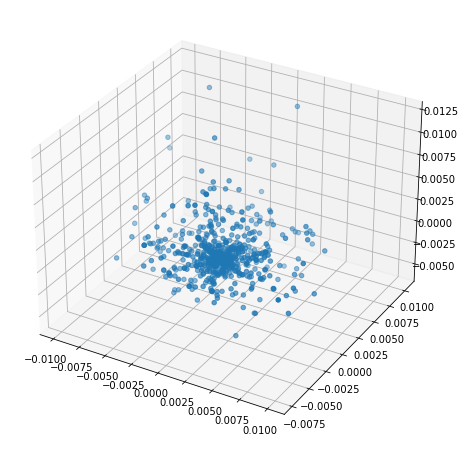

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca.fit(user_embeddings)
user_embeddings_pca = # TODO 3: Your code here

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = "3d")
xs, ys, zs = user_embeddings_pca[::150].T
ax.scatter(xs, ys, zs)

## OPTIONAL: Run on Cloud

In [31]:
%%bash
gsutil -m cp data/* gs://${BUCKET}/wals/data

Copying file://data/collab_mapped.csv [Content-Type=text/csv]...
Copying file://data/collab_raw.csv [Content-Type=text/csv]...                   
Copying file://data/items.csv [Content-Type=text/csv]...                        
Copying file://data/items_for_user [Content-Type=application/octet-stream]...   
Copying file://data/users_for_item [Content-Type=application/octet-stream]...   
Copying file://data/users.csv [Content-Type=text/csv]...                        
- [6/6 files][ 35.7 MiB/ 35.7 MiB] 100% Done                                    
Operation completed over 6 objects/35.7 MiB.                                     


In [32]:
%%bash
OUTDIR=gs://${BUCKET}/wals/model_trained
JOBNAME=wals_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=walsmodel.task \
    --package-path=${PWD}/walsmodel \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --input_path=gs://${BUCKET}/wals/data \
    --num_epochs=10 --nitems=${NITEMS} --nusers=${NUSERS} 

gs://qwiklabs-gcp-01-7f6e984e70dc/wals/model_trained us-central1 wals_220516_174236
jobId: wals_220516_174236
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [wals_220516_174236] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe wals_220516_174236

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs wals_220516_174236


This will take <b>10 minutes</b> to complete. Rerun the above command until the jobs gets submitted.

<pre>
# Copyright 2022 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>